# Seq2Seq + Attention Train

> 2. 모델 학습

In [1]:
# 모듈 불러오기
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.layers import Permute, Activation, Dot, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import pickle

from IPython.display import SVG
from keras.utils import model_to_dot

In [35]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"
chatbot_path = f"{root_path}/Seq2Seq-Chatbot"

## 데이터 로드

In [19]:
# 어휘집 사전
with open(f"{data_path}/6-1.vocabulary.pickle", 'rb') as f:
    word2idx, idx2word = pickle.load(f)

In [36]:
# 학습 데이터: 인코딩, 디코딩 입력, 디코딩 출력
with open(f"{data_path}/6-1.train_data.pickle", 'rb') as f:
    X_train_E, X_train_D, y_train_D = pickle.load(f)

# 테스트 데이터: 인코딩, 디코딩 입력, 디코딩 출력
with open(f"{data_path}/6-1.eval_data.pickle", 'rb') as f:
    X_test_E, X_test_D, y_test_D = pickle.load(f)

## 모델 구성

In [37]:
def Attention(x, y):
    '''
    x: encoder 출력
    y: decoder 출력
    return: concatenated tensors
    '''
    # 1. dot: decoder 매 시점마다 encoder 전체 시점과 dot-product.
    score = Dot(axes=(2,2))([y,x])
    # 2. softmax
    dist = Activation('softmax')(score)
    # 3. 가중평균
    score = Dot(axes=(3, 1))([tf.expand_dims(dist, 0), x])
    # 4. sum
    score = tf.reduce_sum(score, axis=1)
    
    return Concatenate()([score, y]) # 5. concat

In [38]:
# 모델 파라미터 설정
VOCAB_SIZE = len(idx2word)
EMB_SIZE = int(input('임베딩 출력 차원 설정: '))
LSTM_HIDDEN = int(input('LSTM 은닉 노드 수 설정: '))
MODEL_PATH = f"{chatbot_path}/Seq2Seq_attention.h5"

임베딩 출력 차원 설정: 128
LSTM 은닉 노드 수 설정: 128


In [39]:
# 세션 클리어
K.clear_session()

# 공통 임베딩 레이어
wordEmbedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)

In [40]:
# Encoder 네트워크 구성
E_input = Input(batch_shape=(None, X_train_E.shape[1]))
E_embed = wordEmbedding(E_input)
E_lstm1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
E_lstm2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
ey1, eh1, ec1 = E_lstm1(E_embed)
ey2, eh2, ec2 = E_lstm2(ey1) # 1층의 출력을 받는다

In [41]:
# Decoder 네트워크 구성
D_input = Input(batch_shape=(None, X_train_D.shape[1]))
D_embed = wordEmbedding(D_input)
D_lstm1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
D_lstm2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
dy1, dh1, dc1 = D_lstm1(D_embed, initial_state=[eh1, ec1]) # 초기 상태 설정
dy2, dh2, dc2 = D_lstm2(dy1, initial_state=[eh2, ec2]) # 초기 상태 설정

In [42]:
# Attention 네트워크 구성
attention = Attention(ey2, dy2)

In [43]:
# 출력 네트워크
y_output = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax')) # 시간 분배
y_output = y_output(attention)

========== 모델 전체 구조 확인 ==========
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 128)      2650240     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 10, 128), (N 

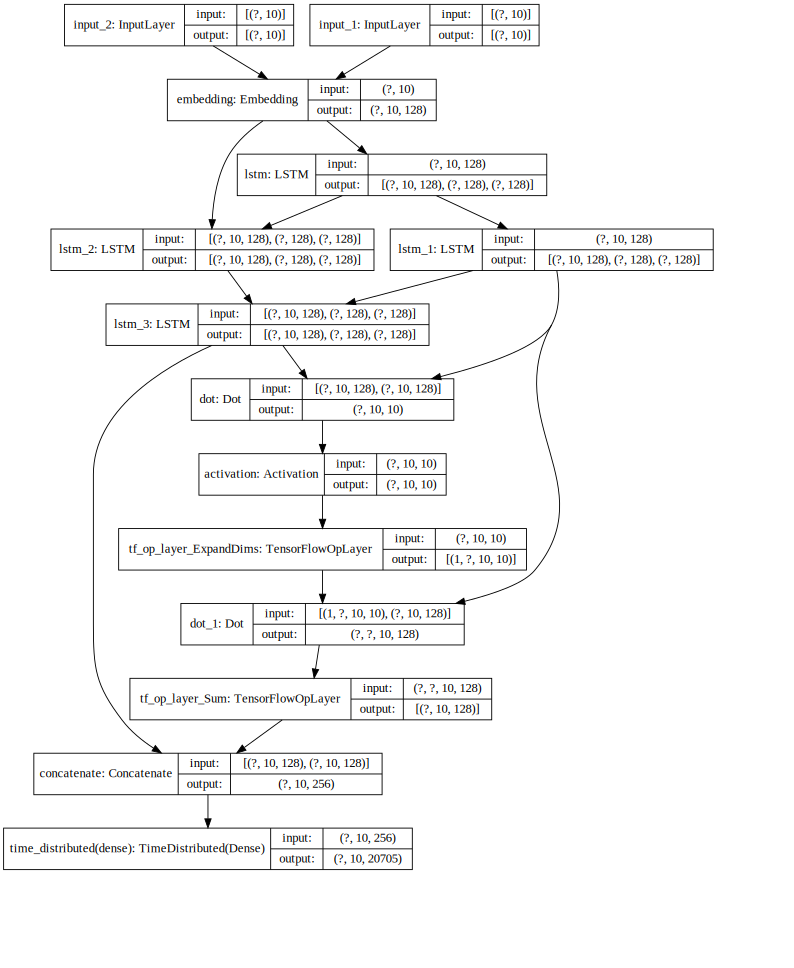

In [44]:
# 모델 구성
model = Model([E_input, D_input], y_output)
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy')
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

## 학습

In [45]:
LOAD_MODEL = True

if LOAD_MODEL :
    model.load_weights(MODEL_PATH)

# teacher forcing 학습
hist = model.fit([X_train_E, X_train_D], y_train_D,
                 batch_size=300,
                 epochs=500,
                 shuffle=True,
                 validation_data=([X_test_E, X_test_D], y_test_D))

Epoch 1/500
36/36 [==============================] - 4s 98ms/step - loss: 5.0025 - val_loss: 3.6796
Epoch 2/500
36/36 [==============================] - 3s 71ms/step - loss: 3.4959 - val_loss: 3.4834
Epoch 3/500
36/36 [==============================] - 3s 71ms/step - loss: 3.2408 - val_loss: 3.3400
Epoch 4/500
36/36 [==============================] - 3s 71ms/step - loss: 3.0304 - val_loss: 3.2446
Epoch 5/500
36/36 [==============================] - 3s 70ms/step - loss: 2.7301 - val_loss: 3.1647
Epoch 6/500
36/36 [==============================] - 3s 71ms/step - loss: 2.2290 - val_loss: 3.1439
Epoch 7/500
36/36 [==============================] - 3s 71ms/step - loss: 1.6680 - val_loss: 3.2086
Epoch 8/500
36/36 [==============================] - 3s 71ms/step - loss: 1.2688 - val_loss: 3.2680
Epoch 9/500
36/36 [==============================] - 3s 70ms/step - loss: 1.0555 - val_loss: 3.2711
Epoch 10/500
36/36 [==============================] - 3s 70ms/step - loss: 0.9144 - val_loss: 3.3086

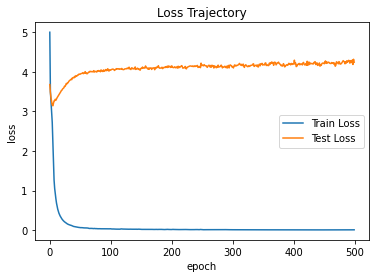

In [46]:
# loss 시각화 : 첫 번째 학습
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('Loss Trajectory')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [47]:
# 학습 결과 저장
model.save_weights(MODEL_PATH)